<h1><center> Facial Emotion Recognition - XCeption Model</center></h1>
<center> A project for the French Employment Agency </center>
<center> Telecom ParisTech 2018-2019 </center>

# I. Context

The aim of this notebook is to explore facial emotion recognition techniques from a live webcam video stream. 

The data set used for training is the Kaggle FER2013 emotion recognition data set : https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data

The models explored include :
- Manual filters 
- Deep Learning Architectures
- DenseNet Inspired Architectures

This model will be combined with voice emotion recongition as well as psychological traits extracted from text inputs, and should provide a benchmark and a deep analysis of both verbal and non-verbal insights for candidates seeking for a job and their performance during an interview.

# II. General imports

Versions used :

In [5]:
### General imports ###
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from time import sleep
import re
import os
import argparse
from collections import OrderedDict
import matplotlib.animation as animation

### Image processing ###
from scipy.ndimage import zoom
from scipy.spatial import distance
import imutils
from scipy import ndimage
import cv2
import dlib
from __future__ import division
from imutils import face_utils

### CNN models ###
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from keras.utils import np_utils
from keras.regularizers import l2#, activity_l2
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
from keras import models
from keras.utils.vis_utils import plot_model
from keras.layers import Input, GlobalAveragePooling2D
from keras.models import Model
from tensorflow.keras import layers

### Build SVM models ###
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm

### Same trained models ###
import h5py
from keras.models import model_from_json
import pickle

# III. Import datas

In [12]:
path = '/Users/aryasoni/Documents/GitHub/AI-Interview/Video/'
local_path = '/Users/aryasoni/Documents/GitHub/AI-Interview/Video/'

In [13]:
X_train = np.load(local_path + "X_train.npy")
X_test = np.load(local_path + "X_test.npy")
y_train = np.load(local_path + "y_train.npy")
y_test = np.load(local_path + "y_test.npy")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/aryasoni/Documents/GitHub/AI-Interview/Video/X_train.npy'

In [14]:
shape_x = 48
shape_y = 48
nRows,nCols,nDims = X_train.shape[1:]
input_shape = (nRows, nCols, nDims)
classes = np.unique(y_train)
nClasses = len(classes)

NameError: name 'X_train' is not defined

# IV. XCeption Model

In [5]:
def entry_flow(inputs) :
    
    x = Conv2D(32, 3, strides = 2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64,3,padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    previous_block_activation = x
    
    for size in [128, 256, 728] :
    
        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)
    
        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)
        
        x = MaxPooling2D(3, strides=2, padding='same')(x)
        
        residual = Conv2D(size, 1, strides=2, padding='same')(previous_block_activation)
        
        x = keras.layers.Add()([x, residual])
        previous_block_activation = x
    
    return x

In [6]:
def middle_flow(x, num_blocks=8) :
    
    previous_block_activation = x
    
    for _ in range(num_blocks) :
    
        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)
    
        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)
        
        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)
        
        x = keras.layers.Add()([x, previous_block_activation])
        previous_block_activation = x
    
    return x

In [7]:
def exit_flow(x, num_classes=7) :
    
    previous_block_activation = x
    
    x = Activation('relu')(x)
    x = SeparableConv2D(728, 3, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = MaxPooling2D(3, strides=2, padding='same')(x)
    
    residual = Conv2D(1024, 1, strides=2, padding='same')(previous_block_activation)
    x = keras.layers.Add()([x, residual])
      
    x = Activation('relu')(x)
    x = SeparableConv2D(728, 3, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)
    
    return x

In [8]:
inputs = Input(shape=(shape_x, shape_y, 1))
outputs = exit_flow(middle_flow(entry_flow(inputs)))

In [9]:
xception = Model(inputs, outputs)

In [10]:
plot_model(xception, to_file='model_images/model_plot_4.png', show_shapes=True, show_layer_names=True)

<img src='model_images/model_plot_4.png'>

In [75]:
xception.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 24, 24, 32)   320         input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_73 (BatchNo (None, 24, 24, 32)   128         conv2d_28[0][0]                  
__________________________________________________________________________________________________
activation_74 (Activation)      (None, 24, 24, 32)   0           batch_normalization_73[0][0]     
__________________________________________________________________________________________________
conv2d_29 

In [76]:
xception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
 
batch_size = 128
epochs = 150

In [ ]:
datagen = ImageDataGenerator(
        zoom_range=0.2,          # randomly zoom into images
        rotation_range=10,       # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,   # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,    # randomly flip images
        vertical_flip=False)     # randomly flip images

history = xception.fit_generator(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=int(np.ceil(X_train.shape[0] / float(batch_size))),
    epochs = epochs, 
    validation_data=(X_test, y_test)
)

Epoch 1/150
225/225 [==============================] - 2132s 9s/step - loss: 1.7515 - acc: 0.2968 - val_loss: 2.3387 - val_acc: 0.2644
Epoch 2/150
 49/225 [=====>........................] - ETA: 25:20 - loss: 1.5588 - acc: 0.3881

# V. Evaluate the model

Text(0.5, 1.0, 'Accuracy Curves')

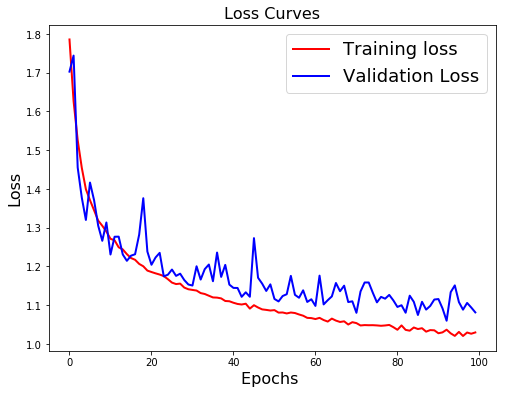

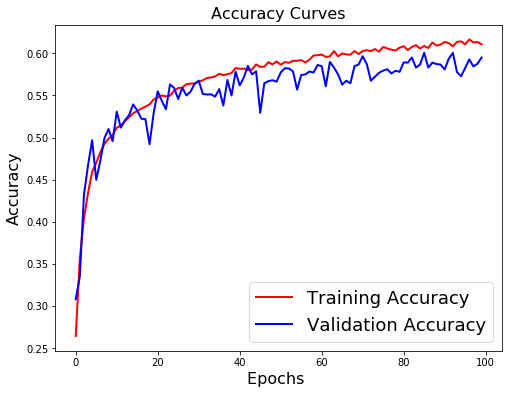

In [334]:
#Plotting accuracy and loss curves for 2nd model

# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=2.0)
plt.plot(history.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=2.0)
plt.plot(history.history['val_acc'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

# VI. Save the model

In [332]:
#save the model weights
json_string = model.to_json()
model.save_weights(local_path + 'savedmodels/model_xception.h5')
open(local_path + 'savedmodels/model_xception.json', 'w').write(json_string)
#model.save_weights(local_path + 'savedmodels/Emotion_Face_Detection_Model.h5')

17443

# VII. Sources

- Visualization : https://github.com/JostineHo/mememoji/blob/master/data_visualization.ipynb
- State of the art Architecture : https://github.com/amineHorseman/facial-expression-recognition-using-cnn
- Eyes Tracking : https://www.pyimagesearch.com/2017/04/24/eye-blink-detection-opencv-python-dlib/
- Face Alignment : https://www.pyimagesearch.com/2017/05/22/face-alignment-with-opencv-and-python/
- C.Pramerdorfer,  and  M.Kampel.Facial  Expression  Recognition  using  Con-volutional  Neural  Networks:  State  of  the  Art.  Computer  Vision  Lab,  TU  Wien. https://arxiv.org/pdf/1612.02903.pdf
- A Brief Review of Facial Emotion Recognition Based
on Visual Information : https://www.mdpi.com/1424-8220/18/2/401/pdf
- Going deeper in facial expression recognition using deep neural networks : https://ieeexplore.ieee.org/document/7477450